<h4>
<ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">OBJECTIVE:</span></strong></li>
</ul>
<p><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Use the text data to build simple feed-forward Neural Nets and benchmark against the base ML models.</span></p>
    </h4>

In [1]:
# imports

import os
import math
import random
import warnings
from time import time
from pathlib import Path
import pandas as pd, numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict, Counter
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud, STOPWORDS
import tensorflow

tqdm.pandas()
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

C:\Users\surya\anaconda3\envs\full\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
# reproducibility
seed = 7
random.seed(seed)
tensorflow.random.set_seed(seed)

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Import the clean data.</span></strong></li>
</ul></h3>

In [3]:
dataset = pd.read_excel('./data/cleaned_data.xlsx')
dataset.sample(10)

,short_description,description,caller,group,char_length,word_length,short_char_length,short_word_length,description_keywords,short_description_keywords,group_code,char_length_bins,cleaned_description,cleaned_short_description,cleaned_char_length,cleaned_word_length,cleaned_short_char_length,cleaned_short_word_length
2600,job Job_534 failed in job_scheduler at: 10/01/...,received from: monitoring_tool@company.com\n\n...,bpctwhsn kzqsbmtp,GRP_8,105,11,61,8,job Job,job Job,72,12,job job 534 fail job scheduler 01 04 00,job job 534 fail job scheduler 01 04 00,39,9,39,9
2113,4908206193/00001 dn required by 2 oclock est,\n\nreceived from: kaguhxwo.uoyipxqg@gmail.com...,kaguhxwo uoyipxqg,GRP_6,135,17,44,7,warehouse today before they cut,oclock est,56,16,create dn 5019317204 00001 warehouse today cut...,4908206193 00001 dn require 2 clock e,51,8,37,7
5215,unable to connect to company wi-fi,unable to connect to company wi-fi,ntuhoafg bzwefjvk,GRP_0,35,6,35,6,unable to connect to company,unable to connect to company,0,4,unable connect company wi fi,unable connect company wi fi,28,5,28,5
5068,netweaver -,\n\nreceived from: bcxpeuko.utorqehx@gmail.com...,bcxpeuko utorqehx,GRP_0,176,21,12,2,update the netweaver,netweaver,0,20,help update netweaver receive message,netweaver,37,5,9,1
4093,HostName_170- swap space on:HostName_170 is 75...,HostName_170- swap space on:HostName_170 is 75...,spxqmiry zpwgoqju,GRP_47,55,8,55,8,HostName,HostName,42,6,hostname 170 swap space hostname 170 75 less,hostname 170 swap space hostname 170 75 less,44,8,44,8
6155,it help for engineering_tool and engineering_...,"dear sir,\n\nplease help to download software ...",vxhyftae tbkyfdli,GRP_0,248,41,50,6,dear sir,engineering,0,26,dear help download software engineering tool e...,help engineer tool engineering tool,172,23,35,5
5578,i need access to the deleted folder on collabo...,i can't find a mti certificate tracking form o...,hdfcwmag plxstkad,GRP_16,111,18,62,9,certificate tracking form on collaboration,deleted folder on collaboration,8,13,ca t find mti certificate tracking form collab...,need access delete folder collaboration platform,86,14,48,6
4198,"milano,italy: duplex mismatch gi2/0/1 on 1811...",duplex mismatch: duplex mode on interface giga...,mnlazfsr mtqrkhnx,GRP_4,531,66,112,17,duplex mode matches,duplex mismatch,34,42,duplex mismatch duplex mode interface gigabite...,milano italy duplex mismatch gi2 0 1 1811 rout...,330,50,89,17
1556,grir issues plant_322 for ice alt. routes from...,email from maryhtutina bauuyternfeyt to athynd...,cbligfne wmoxktnj,GRP_53,443,63,50,9,maryhtutina bauuyternfeyt to athyndy eartyp,grir issues plant,49,38,email maryhtutina bauuyternfeyt athyndy eartyp...,grir issue plant 322 ice alt route usa,324,44,38,8
852,pc rqxw8515267 setup for remote company use ca...,pc rqxw8515267 setup for remote company use ca...,xweclugf qmhbjsyi,GRP_3,111,19,111,19,setup for remote company,setup for remote company,23,13,pc rqxw8515267 setup remote company use log ap...,pc rqxw8515267 setup remote company use log ap...,72,11,72,11


In [4]:
dataset.isna().sum()

short_description              0
description                    0
caller                         0
group                          0
char_length                    0
word_length                    0
short_char_length              0
short_word_length              0
description_keywords           7
short_description_keywords    38
group_code                     0
char_length_bins               0
cleaned_description            0
cleaned_short_description      0
cleaned_char_length            0
cleaned_word_length            0
cleaned_short_char_length      0
cleaned_short_word_length      0
dtype: int64

In [5]:
dataset.loc[dataset["group"] != 'GRP_0', 'group'] = 'Other'
dataset.loc[dataset["group"] == 'GRP_0', "group"] = 'Group 0'

In [6]:
dataset.group.value_counts()

Other      4473
Group 0    3959
Name: group, dtype: int64

In [7]:
le = LabelEncoder()
dataset['group_code'] = le.fit_transform(dataset.group)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8432 entries, 0 to 8431
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   short_description           8432 non-null   object
 1   description                 8432 non-null   object
 2   caller                      8432 non-null   object
 3   group                       8432 non-null   object
 4   char_length                 8432 non-null   int64 
 5   word_length                 8432 non-null   int64 
 6   short_char_length           8432 non-null   int64 
 7   short_word_length           8432 non-null   int64 
 8   description_keywords        8425 non-null   object
 9   short_description_keywords  8394 non-null   object
 10  group_code                  8432 non-null   int32 
 11  char_length_bins            8432 non-null   int64 
 12  cleaned_description         8432 non-null   object
 13  cleaned_short_description   8432 non-null   obje

In [8]:
le.classes_

array(['Group 0', 'Other'], dtype=object)

In [9]:
def merge_descriptions(row):
    merged_descr = np.nan
    if (row.cleaned_short_description == row.cleaned_description or 
        str(row.description).startswith(str(row.cleaned_short_description))):
        merged_descr = str(row.cleaned_description)
    else:
        merged_descr = str(row.cleaned_short_description) + " " + str(row.cleaned_description)
    row['merged_description'] = str(merged_descr)
    return row

dataset = dataset.progress_apply(merge_descriptions, axis=1)

100%|██████████████████████████████████████████████████████████████████████████| 8432/8432 [00:10<00:00, 823.10it/s]


In [10]:
dataset[['cleaned_short_description', 'cleaned_description', 'merged_description']].sample(10)

,cleaned_short_description,cleaned_description,merged_description
6628,vpn connection issue,vpn connection issue connect user system use t...,vpn connection issue connect user system use t...
753,job bk biaprod fail job scheduler 05 12 00,job bk biaprod fail job scheduler 05 12 00,job bk biaprod fail job scheduler 05 12 00
5807,window printing issue need driver instal every...,window printing issue need driver instal every...,window printing issue need driver instal every...
7788,abende job job scheduler job 1148,abende job job scheduler job 1148 01 15 24,abende job job scheduler job 1148 abende job j...
2974,unable login ess protel,unable login ess portal,unable login ess protel unable login ess portal
6821,user unable login erp,user unable login erp,user unable login erp
2530,bex analyzer bex designer work,bex analyzer bex designer work,bex analyzer bex designer work
7194,setup new ws gonzale,setup new ws gonzale,setup new ws gonzale
6523,open pptx file attach email give repair error,open pptx file attach email give repair error,open pptx file attach email give repair error
7671,abende job job scheduler sid 38hotf,abende job job scheduler sid 38hotf 23 06 26,abende job job scheduler sid 38hotf abende job...


In [11]:
X = np.array(dataset.merged_description)
y = np.array(dataset.group_code)
X.shape, y.shape

((8432,), (8432,))

In [12]:
from tensorflow.keras.utils import to_categorical
y_dummy_coded = to_categorical(y)
y[0], y_dummy_coded[0]

(0, array([1., 0.], dtype=float32))

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_dummy_coded, test_size=.2, random_state=seed)  # splits are stratified by y

In [14]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6745,), (1687,), (6745, 2), (1687, 2))

In [15]:
X_train[0], y_train[0]  # check sample

('additional correction sale org 1278 company address phone number require germany move 1 sale organisation address 1278 phone number fax number need reverse original phone fax number furth 0911 2 plant address plant 124 phone fax number need adjusted show germany central phone number fax 3 company code address 5278 need revert back address furth germany detail attach ticket',
 array([0., 1.], dtype=float32))

In [16]:
# TODO: Check the distributions of groups in training and testing sets, i.e, if they vary too much
# stratify by y if required during splits
# or data augmentation to upsample minority classes to balance the group distributions

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Tokenize and pad sequences</span></strong></li>
</ul></h3>

In [17]:
# define params
NUM_WORDS = 20000
EMBEDDING_DIM = 300
MAX_LEN = 100 # dataset['word_length'].max()
MAX_LEN

100

In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


tokenizer = Tokenizer(num_words=NUM_WORDS)
tokenizer.fit_on_texts(X_train)
X_train_tokens = tokenizer.texts_to_sequences(X_train)
X_test_tokens = tokenizer.texts_to_sequences(X_test)
X_train_tokens[0], X_test_tokens[0]

([184,
  2093,
  93,
  606,
  1609,
  10,
  148,
  45,
  116,
  169,
  146,
  375,
  15,
  93,
  6817,
  148,
  1609,
  45,
  116,
  1513,
  116,
  23,
  1729,
  674,
  45,
  1513,
  116,
  804,
  6818,
  30,
  75,
  148,
  75,
  2370,
  45,
  1513,
  116,
  23,
  4267,
  90,
  146,
  3354,
  45,
  116,
  1513,
  73,
  10,
  188,
  148,
  6819,
  23,
  1195,
  174,
  148,
  804,
  146,
  117,
  88,
  17],
 [93, 2095, 280, 1029, 783, 355, 9, 2095, 1029, 1360, 2095, 211, 280])

In [19]:
y_train[0], y_test[0]

(array([0., 1.], dtype=float32), array([0., 1.], dtype=float32))

In [20]:
# pad sequences to cut longer texts to a uniform length and pad the sentences that are shorter than that with <PAD> token

# using just 20 words from each headline will severely limit the information that is 
# available to the model and affect performance although the training will be faster
X_train_padded = pad_sequences(X_train_tokens,
                               padding='post',
                               truncating='post',
                               maxlen=MAX_LEN)
X_test_padded = pad_sequences(X_test_tokens,
                              padding='post',
                              truncating='post',
                              maxlen=MAX_LEN)


print(f'X train:  {X_train_padded.shape}\nX test:   {X_test_padded.shape}')

X train:  (6745, 100)
X test:   (1687, 100)


In [21]:
pprint(X_train_padded[0], compact=True)

array([ 184, 2093,   93,  606, 1609,   10,  148,   45,  116,  169,  146,
        375,   15,   93, 6817,  148, 1609,   45,  116, 1513,  116,   23,
       1729,  674,   45, 1513,  116,  804, 6818,   30,   75,  148,   75,
       2370,   45, 1513,  116,   23, 4267,   90,  146, 3354,   45,  116,
       1513,   73,   10,  188,  148, 6819,   23, 1195,  174,  148,  804,
        146,  117,   88,   17,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0])


In [22]:
WORD_TO_INDEX = tokenizer.word_index
# pprint(WORD_TO_INDEX, compact=True)
pprint(list(WORD_TO_INDEX.keys())[:100], compact=True)

['job', 'yes', 'na', 'password', 'erp', 'tool', 'user', 'ts', 'issue',
 'company', 'sid', 'reset', 'access', 'scheduler', '1', '00', 'ticket',
 'unable', 'work', 'error', 'fail', 'account', 'need', 'email', 'site', 'help',
 'system', 'hostname', 'get', '2', 'login', 'circuit', 'power', 'outlook',
 'network', 'use', 'vendor', 'change', '34', 'update', 'name', 'message',
 'backup', 'see', 'phone', 'telecom', 'server', 'try', '10', 'able', 'outage',
 'log', 'check', 'new', 'problem', 'start', 'crm', 'engineering', 'request',
 'connect', 'call', 'usa', 'type', 'time', 'printer', 'order', 'report', 'vpn',
 'team', 'open', 'contact', 'skype', '3', 'lock', 'plant', 'et', 't', 'send',
 'create', '4', '5', 'window', 'file', 'pc', 'since', 'print', 'schedule',
 'attach', 'device', 'show', '8', 'maintenance', 'sale', '11', '12', 'receive',
 'abende', 'notify', '23', 'management']


In [23]:
VOCAB_SIZE = len(WORD_TO_INDEX) + 1
VOCAB_SIZE

13790

In [24]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
def retrieve_description_feat(x, mapping=WORD_TO_INDEX) -> str:
    # increment 3 
    mapping = {k:(v + 3) for k, v in mapping.items()}
    mapping['<PAD>'] = 0
    mapping['<START>'] = 1
    mapping['<UNK>'] = 2
    inv_mapping = {v: k for k, v in mapping.items()}
    return str(" ".join(inv_mapping.get(i, '<NA>') for i in x))

retrieve_description_feat(X_test_padded[7])

'1 22 team response complaint synchronize <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>'

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">GloVe Embeddings</span></strong></li>
</ul></h3>

In [25]:
EMBEDDING_DIM

300

In [26]:
def get_embedding_matrix(embedding_dim=EMBEDDING_DIM):
    embeddings = defaultdict()
    if embedding_dim == 200:
        file_path = f'./data/glove.6B.{embedding_dim}d.txt'
    elif embedding_dim == 300:
        file_path = f'./data/glove.840B.{embedding_dim}d.txt'
    for l in open(file_path, encoding='utf-8'):
        word = l.split(" ")[0]
        embeddings[word] = np.asarray(l.split(" ")[1:], dtype='float32')

    embeddings = dict(embeddings)

    # create a weight matrix for words in training docs
    embedding_matrix = np.zeros((NUM_WORDS, embedding_dim))

    for word, idx in WORD_TO_INDEX.items():
        embedding_vector = embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector

    return embedding_matrix

In [27]:
# use pre-trained glove embedding matrix to initialize weights in our model
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(20000, 300)

<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Simple Feed-Forward Neural Net</span></strong></li>
</ul></h4>

In [54]:
# !pip install livelossplot
from tensorflow.python.keras.models import Sequential
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import max_norm, unit_norm
from tensorflow.python.keras.callbacks import LambdaCallback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Flatten, Dense, Activation, BatchNormalization, Dropout, Embedding, LSTM, MaxPooling1D, Conv1D, Bidirectional

In [29]:
NUM_CLASSES = len(le.classes_)
VOCAB_SIZE, MAX_LEN, EMBEDDING_DIM, NUM_CLASSES

(13790, 100, 300, 2)

In [30]:
# define model

model1 = Sequential([ 
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
    Flatten(),
    Dense(1024, activation = 'relu'),
    Dense(1024, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(NUM_CLASSES, activation = 'softmax')
])

model1.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [31]:
# Define Callbacks and a few helper functions

# simplify the training log
simple_log = LambdaCallback(
    on_epoch_end = lambda e, l: print(f" ~| Epoch: {e+1} | Validation Loss: {l['val_loss']:.5f}", end =" >|> \n" ))

# early stopping
early_stop = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=7,
                              verbose=0, 
                              restore_best_weights=True)

# learning rate reduction
lr_reduce_on_plateau = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.4,
                                            min_lr=0.00001)

def plot_learning_curve(hist):
    sns.set()
    plt.figure(figsize=(5,5))
    train = hist.history['loss']
    val = hist.history['val_loss']
    epochs_run = range(1,len(train) + 1)
    sns.lineplot(epochs_run, train, marker = 'o', color = 'coral', label = 'Training Loss')
    sns.lineplot(epochs_run, val,  marker = '>', color = 'green', label = 'Validation Loss')
    plt.title("Loss vs. Epochs", fontsize = 20)
    plt.legend()
    plt.show()

In [32]:
X_train[0]

'additional correction sale org 1278 company address phone number require germany move 1 sale organisation address 1278 phone number fax number need reverse original phone fax number furth 0911 2 plant address plant 124 phone fax number need adjusted show germany central phone number fax 3 company code address 5278 need revert back address furth germany detail attach ticket'

In [33]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6745,), (6745, 2), (1687,), (1687, 2))

In [34]:
EPOCHS = 200
try:
    print("Training on GPU:")
    with tensorflow.device("gpu:0"):  # train on gpu
        h1 = model1.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop, lr_reduce_on_plateau],
            verbose = False)
except Exception as e:
    print(e)
    print("\nTraining on CPU:")
    h1 = model1.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop, lr_reduce_on_plateau],
            verbose = False)

print("\nTraining Done.")

Training on GPU:
 ~| Epoch: 1 | Validation Loss: 0.33744 >|> 
 ~| Epoch: 2 | Validation Loss: 0.43625 >|> 
 ~| Epoch: 3 | Validation Loss: 0.56031 >|> 
 ~| Epoch: 4 | Validation Loss: 0.71875 >|> 
 ~| Epoch: 5 | Validation Loss: 0.80328 >|> 

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
 ~| Epoch: 6 | Validation Loss: 0.94813 >|> 
 ~| Epoch: 7 | Validation Loss: 1.10798 >|> 
 ~| Epoch: 8 | Validation Loss: 1.20928 >|> 

Training Done.


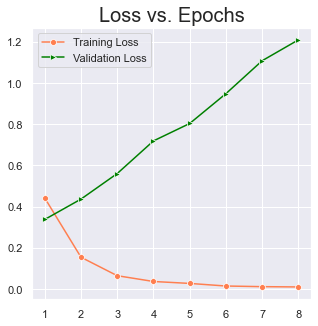

In [35]:
plot_learning_curve(h1)

In [36]:
loss, acc = model1.evaluate(X_test_padded, y_test)
print("Testing Loss: ", loss*100)
print("Testing Accuracy: ", acc*100)

53/53 [==============================] - 0s 6ms/step - loss: 0.3273 - accuracy: 0.8625
Testing Loss:  32.73244500160217
Testing Accuracy:  86.24777793884277


<h4><ul>
<span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">
    <li>This model is clearly overfitting, we will add regularization to the next iteration
 </span></ul></h4>

<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Simple Feed-Forward Neural Net + Batch Normalization</span></strong></li>
</ul></h4>

In [37]:
# define model

model2 = Sequential([ 
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
    Flatten(),
    Dense(256, activation = 'relu'),
    BatchNormalization(),
    Dense(256, activation = 'relu'),
    BatchNormalization(),
    Dense(NUM_CLASSES, activation = 'softmax')
])

model2.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [38]:
EPOCHS = 200
try:
    print("Training on GPU:")
    with tensorflow.device("gpu:0"):  # train on gpu
        h2 = model2.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop, lr_reduce_on_plateau],
            verbose = False)
except Exception as e:
    print(e)
    print("Training on CPU:")
    h2 = model2.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop, lr_reduce_on_plateau],
            verbose = False)

print("\nTraining Done.")

Training on GPU:
 ~| Epoch: 1 | Validation Loss: 0.66638 >|> 
 ~| Epoch: 2 | Validation Loss: 0.72617 >|> 
 ~| Epoch: 3 | Validation Loss: 0.44306 >|> 
 ~| Epoch: 4 | Validation Loss: 0.56813 >|> 
 ~| Epoch: 5 | Validation Loss: 0.42626 >|> 
 ~| Epoch: 6 | Validation Loss: 0.52981 >|> 
 ~| Epoch: 7 | Validation Loss: 0.62305 >|> 
 ~| Epoch: 8 | Validation Loss: 0.55789 >|> 
 ~| Epoch: 9 | Validation Loss: 0.90662 >|> 

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
 ~| Epoch: 10 | Validation Loss: 0.51133 >|> 
 ~| Epoch: 11 | Validation Loss: 0.78763 >|> 
 ~| Epoch: 12 | Validation Loss: 0.77035 >|> 

Training Done.


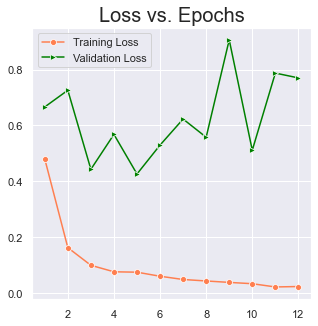

In [39]:
plot_learning_curve(h2)

In [40]:
loss, acc = model2.evaluate(X_test_padded, y_test)
print("Testing Loss: ", loss*100)
print("Testing Accuracy: ", acc*100)

53/53 [==============================] - 0s 9ms/step - loss: 0.4056 - accuracy: 0.8376
Testing Loss:  40.56009352207184
Testing Accuracy:  83.75815153121948


<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Simple Feed-Forward Neural Net + Dropout</span></strong></li>
</ul></h4>

In [41]:
# define model

model3 = Sequential([ 
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
    Flatten(),
    Dense(20, activation = 'relu'),
    Dropout(0.4),
    Dense(NUM_CLASSES, activation = 'softmax')
])

model3.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [42]:
EPOCHS = 200
try:
    print("Training on GPU:")
    with tensorflow.device("gpu:0"):  # train on gpu
        h3 = model3.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop, lr_reduce_on_plateau],
            verbose = False)
except Exception as e:
    print(e)
    print("Training on CPU:")
    h3 = model3.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop, lr_reduce_on_plateau],
            verbose = False)

print("\nTraining Done.")

Training on GPU:
 ~| Epoch: 1 | Validation Loss: 0.38415 >|> 
 ~| Epoch: 2 | Validation Loss: 0.33411 >|> 
 ~| Epoch: 3 | Validation Loss: 0.38989 >|> 
 ~| Epoch: 4 | Validation Loss: 0.49732 >|> 
 ~| Epoch: 5 | Validation Loss: 0.52464 >|> 
 ~| Epoch: 6 | Validation Loss: 0.54575 >|> 

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
 ~| Epoch: 7 | Validation Loss: 0.64775 >|> 
 ~| Epoch: 8 | Validation Loss: 0.67945 >|> 
 ~| Epoch: 9 | Validation Loss: 0.69136 >|> 

Training Done.


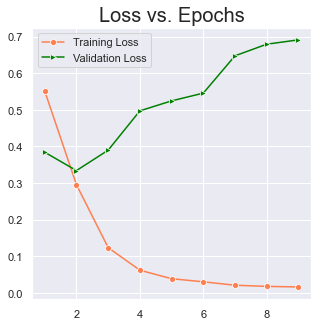

In [43]:
plot_learning_curve(h3)

In [44]:
loss, acc = model3.evaluate(X_test_padded, y_test)
print("Testing Accuracy: ", acc*100)

53/53 [==============================] - 0s 4ms/step - loss: 0.3274 - accuracy: 0.8583
Testing Accuracy:  85.83284020423889


<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Use pre-trained embeddings</span></strong></li>
</ul></h4>

In [45]:
# define model

model3 = Sequential([ 
    Embedding(input_dim=NUM_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_LEN, weights=[embedding_matrix], trainable=True),
    Flatten(),
    Dense(30, activation = 'relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation = 'softmax')
])

model3.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'rmsprop',
    metrics = ['accuracy']
)

In [46]:
EPOCHS = 200
try:
    print("Training on GPU:")
    with tensorflow.device("gpu:0"):  # train on gpu
        h3 = model3.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop, lr_reduce_on_plateau],
            verbose = False)
except Exception as e:
    print(e)
    print("Training on CPU:")
    h3 = model3.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop, lr_reduce_on_plateau],
            verbose = False)

print("\nTraining Done.")

Training on GPU:
 ~| Epoch: 1 | Validation Loss: 0.38540 >|> 
 ~| Epoch: 2 | Validation Loss: 0.41342 >|> 
 ~| Epoch: 3 | Validation Loss: 0.39803 >|> 
 ~| Epoch: 4 | Validation Loss: 0.45770 >|> 
 ~| Epoch: 5 | Validation Loss: 0.50492 >|> 

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
 ~| Epoch: 6 | Validation Loss: 0.56770 >|> 
 ~| Epoch: 7 | Validation Loss: 0.61330 >|> 
 ~| Epoch: 8 | Validation Loss: 0.69508 >|> 

Training Done.


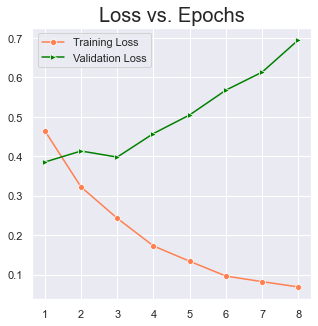

In [47]:
plot_learning_curve(h3)

In [48]:
loss, acc = model3.evaluate(X_test_padded, y_test)
print("Testing Accuracy: ", acc*100)

53/53 [==============================] - 0s 6ms/step - loss: 0.3927 - accuracy: 0.8275
Testing Accuracy:  82.75044560432434


<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">LSTM</span></strong></li>
</ul></h4>

In [49]:
# define model

model4 = Sequential([ 
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
    LSTM(32),
    Dropout(0.4),
    Dense(NUM_CLASSES, activation = 'softmax')
])

model4.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [50]:
EPOCHS = 50
try:
    print("Training on GPU:")
    with tensorflow.device("gpu:0"):  # train on gpu
        h4 = model4.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, lr_reduce_on_plateau],
            verbose = False)
except Exception as e:
    print(e)
    print("Training on CPU:")
    h4 = model4.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, lr_reduce_on_plateau],
            verbose = False)

print("\nTraining Done.")

Training on GPU:
 ~| Epoch: 1 | Validation Loss: 0.68090 >|> 
 ~| Epoch: 2 | Validation Loss: 0.67834 >|> 
 ~| Epoch: 3 | Validation Loss: 0.65052 >|> 
 ~| Epoch: 4 | Validation Loss: 0.67962 >|> 
 ~| Epoch: 5 | Validation Loss: 0.68195 >|> 
 ~| Epoch: 6 | Validation Loss: 0.66145 >|> 
 ~| Epoch: 7 | Validation Loss: 0.67785 >|> 

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
 ~| Epoch: 8 | Validation Loss: 0.55761 >|> 
 ~| Epoch: 9 | Validation Loss: 0.56050 >|> 
 ~| Epoch: 10 | Validation Loss: 0.58099 >|> 
 ~| Epoch: 11 | Validation Loss: 0.61384 >|> 
 ~| Epoch: 12 | Validation Loss: 0.53396 >|> 
 ~| Epoch: 13 | Validation Loss: 0.53542 >|> 
 ~| Epoch: 14 | Validation Loss: 0.52415 >|> 
 ~| Epoch: 15 | Validation Loss: 0.53307 >|> 
 ~| Epoch: 16 | Validation Loss: 0.52474 >|> 
 ~| Epoch: 17 | Validation Loss: 0.53513 >|> 
 ~| Epoch: 18 | Validation Loss: 0.57956 >|> 

Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.00016000000759959222.
 

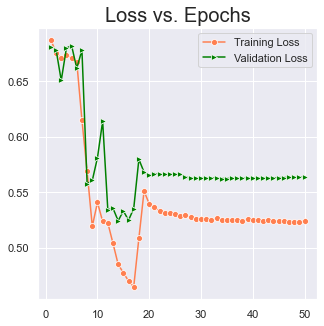

In [51]:
plot_learning_curve(h4)

In [52]:
loss, acc = model4.evaluate(X_test_padded, y_test)
print("Testing Accuracy: ", acc*100)

53/53 [==============================] - 1s 10ms/step - loss: 0.5702 - accuracy: 0.6544
Testing Accuracy:  65.44161438941956


<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Bi-Directional LSTM</span></strong></li>
</ul></h4>

In [55]:
# define model

model4 = Sequential([ 
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
    Bidirectional(LSTM(32)),
    Dropout(0.4),
    Dense(NUM_CLASSES, activation = 'softmax')
])

model4.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'rmsprop',
    metrics = ['accuracy']
)

In [56]:
EPOCHS = 50
try:
    print("Training on GPU:")
    with tensorflow.device("gpu:0"):  # train on gpu
        h4 = model4.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop, lr_reduce_on_plateau],
            verbose = False)
except Exception as e:
    print(e)
    print("Training on CPU:")
    h4 = model4.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop, lr_reduce_on_plateau],
            verbose = False)

print("\nTraining Done.")

Training on GPU:
 ~| Epoch: 1 | Validation Loss: 0.34246 >|> 
 ~| Epoch: 2 | Validation Loss: 0.34657 >|> 
 ~| Epoch: 3 | Validation Loss: 0.35232 >|> 
 ~| Epoch: 4 | Validation Loss: 0.37244 >|> 
 ~| Epoch: 5 | Validation Loss: 0.41386 >|> 

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
 ~| Epoch: 6 | Validation Loss: 0.46064 >|> 
 ~| Epoch: 7 | Validation Loss: 0.49689 >|> 
 ~| Epoch: 8 | Validation Loss: 0.52922 >|> 

Training Done.


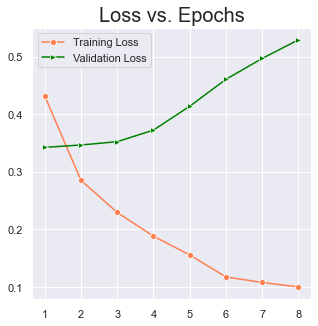

In [57]:
plot_learning_curve(h4)

In [58]:
loss, acc = model4.evaluate(X_test_padded, y_test)
print("Testing Accuracy: ", acc*100)

53/53 [==============================] - 1s 12ms/step - loss: 0.3354 - accuracy: 0.8524
Testing Accuracy:  85.24007201194763


<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">CNN (Dimensionality Reduction) + LSTM</span></strong></li>
</ul></h4>

In [59]:
model5 = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=256, input_length=MAX_LEN),
    Dropout(0.25),
    Conv1D(256, 5, padding = 'same', activation = 'relu', strides = 1),
    Conv1D(256, 5, padding = 'same', activation = 'relu', strides = 1),
    MaxPooling1D(pool_size = 2),
    Conv1D(64, 5, padding = 'same', activation = 'relu', strides = 1),
    MaxPooling1D(pool_size = 2),
    LSTM(75),
    Dense(NUM_CLASSES, activation = 'softmax')
])

model5.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [60]:
EPOCHS = 20
try:
    print("Training on GPU:")
    with tensorflow.device("gpu:0"):  # train on gpu
        h5 = model5.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop, lr_reduce_on_plateau],
            verbose = False)
except Exception as e:
    print(e)
    print("Training on CPU:")
    h5 = model5.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop, lr_reduce_on_plateau],
            verbose = False)

print("\nTraining Done.")

Training on GPU:
 ~| Epoch: 1 | Validation Loss: 0.42078 >|> 
 ~| Epoch: 2 | Validation Loss: 0.41046 >|> 
 ~| Epoch: 3 | Validation Loss: 0.57248 >|> 
 ~| Epoch: 4 | Validation Loss: 0.47355 >|> 
 ~| Epoch: 5 | Validation Loss: 0.73653 >|> 
 ~| Epoch: 6 | Validation Loss: 0.52240 >|> 

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
 ~| Epoch: 7 | Validation Loss: 0.73506 >|> 
 ~| Epoch: 8 | Validation Loss: 0.78235 >|> 
 ~| Epoch: 9 | Validation Loss: 0.80333 >|> 

Training Done.


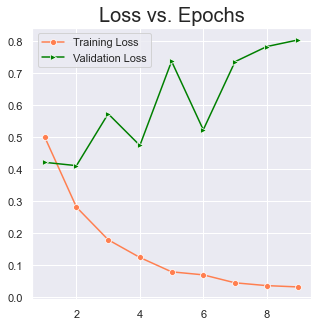

In [61]:
plot_learning_curve(h5)

In [62]:
loss, acc = model5.evaluate(X_test_padded, y_test)
print("Testing Accuracy: ", acc*100)

53/53 [==============================] - 1s 12ms/step - loss: 0.3900 - accuracy: 0.8447
Testing Accuracy:  84.469473361969


<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">CNN (Dimensionality Reduction) + Bi-Directional LSTM</span></strong></li>
</ul></h4>

In [63]:
model5 = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=256, input_length=MAX_LEN),
    Dropout(0.25),
    Conv1D(256, 5, padding = 'same', activation = 'relu', strides = 1),
    Conv1D(256, 5, padding = 'same', activation = 'relu', strides = 1),
    MaxPooling1D(pool_size = 2),
    Conv1D(64, 5, padding = 'same', activation = 'relu', strides = 1),
    MaxPooling1D(pool_size = 2),
    Bidirectional(LSTM(75, recurrent_dropout=0.5)),
    Dense(NUM_CLASSES, activation = 'softmax')
])

model5.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [64]:
EPOCHS = 20
try:
    print("Training on GPU:")
    with tensorflow.device("gpu:0"):  # train on gpu
        h5 = model5.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop, lr_reduce_on_plateau],
            verbose = False)
except Exception as e:
    print(e)
    print("Training on CPU:")
    h5 = model5.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop, lr_reduce_on_plateau],
            verbose = False)

print("\nTraining Done.")

Training on GPU:
 ~| Epoch: 1 | Validation Loss: 0.34703 >|> 
 ~| Epoch: 2 | Validation Loss: 0.34499 >|> 
 ~| Epoch: 3 | Validation Loss: 0.49440 >|> 
 ~| Epoch: 4 | Validation Loss: 0.50982 >|> 
 ~| Epoch: 5 | Validation Loss: 0.63177 >|> 
 ~| Epoch: 6 | Validation Loss: 0.65818 >|> 

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
 ~| Epoch: 7 | Validation Loss: 0.77149 >|> 
 ~| Epoch: 8 | Validation Loss: 0.77925 >|> 
 ~| Epoch: 9 | Validation Loss: 0.82289 >|> 

Training Done.


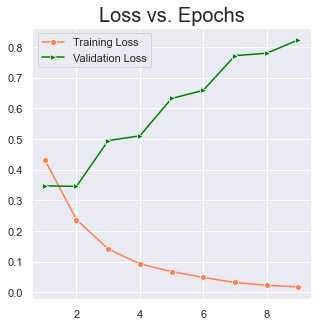

In [65]:
plot_learning_curve(h5)

In [66]:
loss, acc = model5.evaluate(X_test_padded, y_test)
print("Testing Accuracy: ", acc*100)

53/53 [==============================] - 4s 77ms/step - loss: 0.3487 - accuracy: 0.8500
Testing Accuracy:  85.00296473503113


<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Use TfIdf vectors instead of Embedding Layer + Feature Selection</span></strong></li>
</ul></h4>

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# using 75-25 split instead of 50-50 split as we need more data to train neural nets
X_train_vec, X_test_vec, y_train_vec, y_test_vec = train_test_split(X, y, test_size=0.2, random_state=seed)
print(f"Train dataset shape: {X_train_vec.shape}, \nTest dataset shape: {X_test_vec.shape}")

Train dataset shape: (6745,), 
Test dataset shape: (1687,)


In [68]:
NGRAM_RANGE = (1, 2)
TOP_K = 10000
TOKEN_MODE = 'word'
MIN_DOC_FREQ = 2


kwargs = {
    'ngram_range' : NGRAM_RANGE,
    'dtype' : 'int32',
    'strip_accents' : 'unicode',
    'decode_error' : 'replace',
    'analyzer' : TOKEN_MODE,
    'min_df' : MIN_DOC_FREQ
}
vectorizer = TfidfVectorizer(**kwargs)
X_train_vec = vectorizer.fit_transform(X_train_vec)
X_test_vec = vectorizer.transform(X_test_vec)
print(f"Train dataset shape: {X_train_vec.shape}, \nTest dataset shape: {X_test_vec.shape}")

Train dataset shape: (6745, 17085), 
Test dataset shape: (1687, 17085)


In [69]:
from sklearn.feature_selection import SelectKBest, f_classif

# Select best k features, with feature importance measured by f_classif
# Set k as 20000 or (if number of ngrams is less) number of ngrams   
selector = SelectKBest(f_classif, k=min(TOP_K, X_train_vec.shape[1]))
selector.fit(X_train_vec, y_train_vec)
X_train_vec = selector.transform(X_train_vec).astype('float32')
X_test_vec = selector.transform(X_test_vec).astype('float32')
X_train_vec = X_train_vec.toarray()
X_test_vec = X_test_vec.toarray()

print(f"Train dataset shape: {X_train_vec.shape}, \nTest dataset shape: {X_test_vec.shape}")

Train dataset shape: (6745, 10000), 
Test dataset shape: (1687, 10000)


In [70]:
model6 = Sequential([
    Dense(20, activation='relu', input_shape=X_train_vec.shape[1:]),
    Dropout(0.5),
    Dense(20, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model6.compile(
    loss = 'binary_crossentropy',
    optimizer = 'rmsprop',
    metrics = ['accuracy']
)

In [71]:
EPOCHS = 20
try:
    print("Training on GPU:")
    with tensorflow.device("gpu:0"):  # train on gpu
        h6 = model6.fit(
            X_train_vec, y_train_vec,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop],
            verbose = False)
except Exception:
    print("Training on CPU:")
    h6 = model6.fit(
            X_train_vec, y_train_vec,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop],
            verbose = False)

print("\nTraining Done.")

Training on GPU:
 ~| Epoch: 1 | Validation Loss: 0.55280 >|> 
 ~| Epoch: 2 | Validation Loss: 0.38299 >|> 
 ~| Epoch: 3 | Validation Loss: 0.32426 >|> 
 ~| Epoch: 4 | Validation Loss: 0.30529 >|> 
 ~| Epoch: 5 | Validation Loss: 0.30012 >|> 
 ~| Epoch: 6 | Validation Loss: 0.29826 >|> 
 ~| Epoch: 7 | Validation Loss: 0.29672 >|> 
 ~| Epoch: 8 | Validation Loss: 0.29396 >|> 
 ~| Epoch: 9 | Validation Loss: 0.29277 >|> 
 ~| Epoch: 10 | Validation Loss: 0.29358 >|> 
 ~| Epoch: 11 | Validation Loss: 0.29257 >|> 
 ~| Epoch: 12 | Validation Loss: 0.29779 >|> 
 ~| Epoch: 13 | Validation Loss: 0.29718 >|> 
 ~| Epoch: 14 | Validation Loss: 0.30539 >|> 
 ~| Epoch: 15 | Validation Loss: 0.29990 >|> 
 ~| Epoch: 16 | Validation Loss: 0.30262 >|> 
 ~| Epoch: 17 | Validation Loss: 0.30239 >|> 
 ~| Epoch: 18 | Validation Loss: 0.30721 >|> 

Training Done.


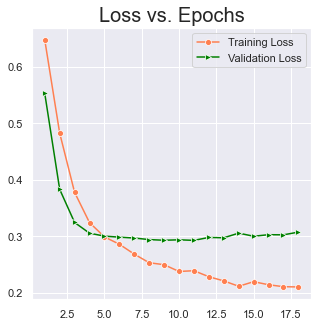

In [72]:
plot_learning_curve(h6)

In [73]:
loss, acc = model6.evaluate(X_test_vec, y_test_vec)
print("Testing Accuracy: ", acc*100)

53/53 [==============================] - 0s 3ms/step - loss: 0.3555 - accuracy: 0.8577
Testing Accuracy:  85.77356338500977


<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Use TfIdf vectors instead of Embedding Layer + Feature Selection + Stratified KFold Training</span></strong></li>
</ul></h4>


Train dataset shape: (7026, 17394), 
Test dataset shape: (1406, 17394)

Features Train dataset shape: (7026, 10000), 
FeaturesTest dataset shape: (1406, 10000)

Epoch 00001: val_accuracy improved from -inf to 0.85064, saving model to models\binary_classfiier\dl\merged_descr\model_1.h5

Epoch 00002: val_accuracy improved from 0.85064 to 0.85989, saving model to models\binary_classfiier\dl\merged_descr\model_1.h5

Epoch 00003: val_accuracy did not improve from 0.85989

Epoch 00004: val_accuracy improved from 0.85989 to 0.86060, saving model to models\binary_classfiier\dl\merged_descr\model_1.h5

Epoch 00005: val_accuracy did not improve from 0.86060

Epoch 00006: val_accuracy did not improve from 0.86060

Epoch 00007: val_accuracy did not improve from 0.86060

Epoch 00008: val_accuracy did not improve from 0.86060

Epoch 00009: val_accuracy did not improve from 0.86060


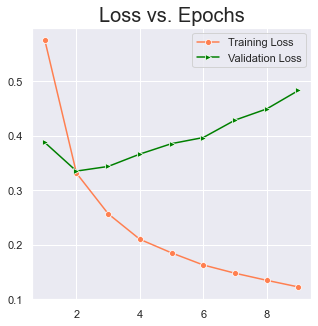

44/44 [==============================] - 0s 7ms/step - loss: 0.3662 - accuracy: 0.8606
Testing Accuracy:  86.05974316596985

Train dataset shape: (7026, 16511), 
Test dataset shape: (1406, 16511)

Features Train dataset shape: (7026, 10000), 
FeaturesTest dataset shape: (1406, 10000)

Epoch 00001: val_accuracy improved from -inf to 0.84068, saving model to models\binary_classfiier\dl\merged_descr\model_2.h5

Epoch 00002: val_accuracy improved from 0.84068 to 0.86060, saving model to models\binary_classfiier\dl\merged_descr\model_2.h5

Epoch 00003: val_accuracy improved from 0.86060 to 0.86415, saving model to models\binary_classfiier\dl\merged_descr\model_2.h5

Epoch 00004: val_accuracy did not improve from 0.86415

Epoch 00005: val_accuracy did not improve from 0.86415

Epoch 00006: val_accuracy did not improve from 0.86415

Epoch 00007: val_accuracy did not improve from 0.86415

Epoch 00008: val_accuracy did not improve from 0.86415

Epoch 00009: val_accuracy did not improve from 0.8

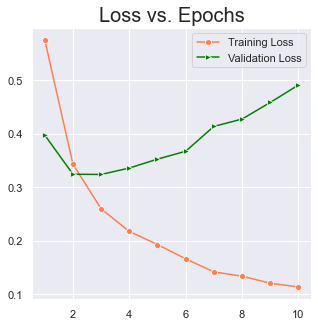

44/44 [==============================] - 0s 6ms/step - loss: 0.3239 - accuracy: 0.8642
Testing Accuracy:  86.41536235809326

Train dataset shape: (7027, 17654), 
Test dataset shape: (1405, 17654)

Features Train dataset shape: (7027, 10000), 
FeaturesTest dataset shape: (1405, 10000)

Epoch 00001: val_accuracy improved from -inf to 0.84413, saving model to models\binary_classfiier\dl\merged_descr\model_3.h5

Epoch 00002: val_accuracy improved from 0.84413 to 0.85765, saving model to models\binary_classfiier\dl\merged_descr\model_3.h5

Epoch 00003: val_accuracy did not improve from 0.85765

Epoch 00004: val_accuracy did not improve from 0.85765

Epoch 00005: val_accuracy did not improve from 0.85765

Epoch 00006: val_accuracy did not improve from 0.85765

Epoch 00007: val_accuracy did not improve from 0.85765

Epoch 00008: val_accuracy did not improve from 0.85765

Epoch 00009: val_accuracy did not improve from 0.85765


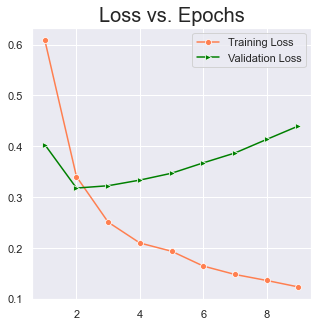

44/44 [==============================] - 0s 3ms/step - loss: 0.3175 - accuracy: 0.8577
Testing Accuracy:  85.76512336730957

Train dataset shape: (7027, 16823), 
Test dataset shape: (1405, 16823)

Features Train dataset shape: (7027, 10000), 
FeaturesTest dataset shape: (1405, 10000)

Epoch 00001: val_accuracy improved from -inf to 0.84342, saving model to models\binary_classfiier\dl\merged_descr\model_4.h5

Epoch 00002: val_accuracy improved from 0.84342 to 0.84840, saving model to models\binary_classfiier\dl\merged_descr\model_4.h5

Epoch 00003: val_accuracy improved from 0.84840 to 0.85480, saving model to models\binary_classfiier\dl\merged_descr\model_4.h5

Epoch 00004: val_accuracy improved from 0.85480 to 0.85907, saving model to models\binary_classfiier\dl\merged_descr\model_4.h5

Epoch 00005: val_accuracy improved from 0.85907 to 0.85979, saving model to models\binary_classfiier\dl\merged_descr\model_4.h5

Epoch 00006: val_accuracy did not improve from 0.85979

Epoch 00007: val

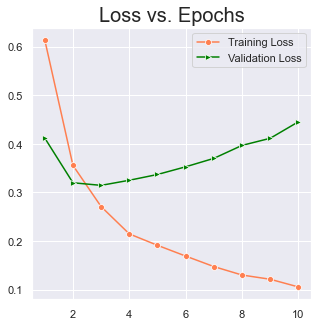

44/44 [==============================] - 0s 3ms/step - loss: 0.3369 - accuracy: 0.8598
Testing Accuracy:  85.97864508628845

Train dataset shape: (7027, 17284), 
Test dataset shape: (1405, 17284)

Features Train dataset shape: (7027, 10000), 
FeaturesTest dataset shape: (1405, 10000)

Epoch 00001: val_accuracy improved from -inf to 0.85979, saving model to models\binary_classfiier\dl\merged_descr\model_5.h5

Epoch 00002: val_accuracy improved from 0.85979 to 0.86121, saving model to models\binary_classfiier\dl\merged_descr\model_5.h5

Epoch 00003: val_accuracy did not improve from 0.86121

Epoch 00004: val_accuracy improved from 0.86121 to 0.86335, saving model to models\binary_classfiier\dl\merged_descr\model_5.h5

Epoch 00005: val_accuracy did not improve from 0.86335

Epoch 00006: val_accuracy did not improve from 0.86335

Epoch 00007: val_accuracy did not improve from 0.86335

Epoch 00008: val_accuracy did not improve from 0.86335

Epoch 00009: val_accuracy did not improve from 0.8

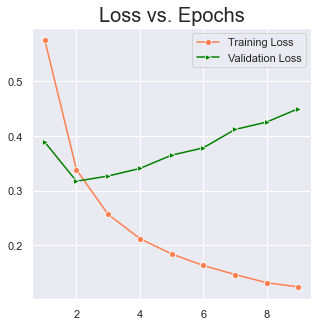

44/44 [==============================] - 0s 8ms/step - loss: 0.3407 - accuracy: 0.8633
Testing Accuracy:  86.3345205783844

Train dataset shape: (7027, 17779), 
Test dataset shape: (1405, 17779)

Features Train dataset shape: (7027, 10000), 
FeaturesTest dataset shape: (1405, 10000)

Epoch 00001: val_accuracy improved from -inf to 0.85552, saving model to models\binary_classfiier\dl\merged_descr\model_6.h5

Epoch 00002: val_accuracy improved from 0.85552 to 0.87117, saving model to models\binary_classfiier\dl\merged_descr\model_6.h5

Epoch 00003: val_accuracy improved from 0.87117 to 0.87829, saving model to models\binary_classfiier\dl\merged_descr\model_6.h5

Epoch 00004: val_accuracy did not improve from 0.87829

Epoch 00005: val_accuracy did not improve from 0.87829

Epoch 00006: val_accuracy did not improve from 0.87829

Epoch 00007: val_accuracy did not improve from 0.87829

Epoch 00008: val_accuracy did not improve from 0.87829

Epoch 00009: val_accuracy did not improve from 0.87

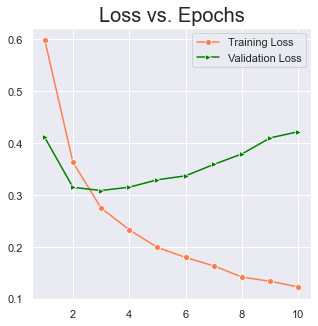

44/44 [==============================] - 0s 7ms/step - loss: 0.3085 - accuracy: 0.8783
Testing Accuracy:  87.82917857170105


In [74]:
from pathlib import Path
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_extraction.text import TfidfVectorizer


def get_model_name(k):
    return f'model_{k}.h5'

NUM_SPLITS = 6
EPOCHS = 20
save_dir = Path('./models/binary_classfiier/dl/merged_descr')
fold_var = 1
NGRAM_RANGE = (1, 2)
TOP_K = 10000
TOKEN_MODE = 'word'
MIN_DOC_FREQ = 2
NUM_CLASSES = 2

kwargs = {
        'ngram_range' : NGRAM_RANGE,
        'dtype' : 'int32',
        'strip_accents' : 'unicode',
        'decode_error' : 'replace',
        'analyzer' : TOKEN_MODE,
        'min_df' : MIN_DOC_FREQ
    }

val_accs = []
skf = StratifiedKFold(n_splits=NUM_SPLITS, shuffle=True, random_state=0)

for train_indices, test_indices in skf.split(X, y):
    X_train_split, X_test_split = X[train_indices], X[test_indices]
    y_train_split, y_test_split = y[train_indices], y[test_indices]
    vectorizer = TfidfVectorizer(**kwargs)
    X_train_vec = vectorizer.fit_transform(X_train_split)
    X_test_vec = vectorizer.transform(X_test_split)
    print(f"\nTrain dataset shape: {X_train_vec.shape}, \nTest dataset shape: {X_test_vec.shape}")
	
    selector = SelectKBest(f_classif, k=min(TOP_K, X_train_vec.shape[1]))
    selector.fit(X_train_vec, y_train_split)
    X_train_vec = selector.transform(X_train_vec).astype('float32')
    X_test_vec = selector.transform(X_test_vec).astype('float32')
    X_train_vec = X_train_vec.toarray()
    X_test_vec = X_test_vec.toarray()

    print(f"\nFeatures Train dataset shape: {X_train_vec.shape}, \nFeaturesTest dataset shape: {X_test_vec.shape}")
    model_ = None
    model_ = Sequential([   
        Dense(20, activation='relu', input_shape=X_train_vec.shape[1:]),
        Dropout(0.5),
        Dense(20, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model_.compile(
        loss = 'binary_crossentropy',
        optimizer = 'adam',
        metrics = ['accuracy']
    )
    
    checkpoint = tensorflow.keras.callbacks.ModelCheckpoint(save_dir / get_model_name(fold_var),
                                                            monitor='val_accuracy',
                                                            verbose=1,
                                                            save_best_only=True,
                                                            mode='max')

    h_ = model_.fit(
            X_train_vec, y_train_split,
            validation_data = (X_test_vec, y_test_split),  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [checkpoint, early_stop],
            verbose = False)
    
    model_.load_weights(save_dir / get_model_name(fold_var))
    plot_learning_curve(h_)
    loss, acc = model_.evaluate(X_test_vec, y_test_split)
    print("Testing Accuracy: ", acc*100)
    val_accs.append(acc)
    tensorflow.keras.backend.clear_session()
    fold_var += 1

In [75]:
print("Testing Accuracy: ", np.mean(val_accs)*100)   # average k fold accuracy

Testing Accuracy:  86.3970955212911


<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Metrics: </span></strong></li>
</ul></h3>

<table style="width:100%">
  <tr>
    <th>Model</th>
    <th>Test Accuracy</th>
  </tr>
  <tr>
    <td>Simple Feed-Forward Net using Embedding Layer</td>
    <td>86.25%</td>
  </tr>
<tr>
    <td>Feed-Forward NN + Batch Norm</td>
    <td>83.76%</td>
  </tr>
<tr>
    <td>Feed-Forward NN + Dropout</td>
    <td>85.83%</td>
  </tr>
    <tr>
    <td>Feed-Forward NN + Pre-trained GloVe embeddings</td>
    <td>82.75%</td>
  </tr>
  <tr>
    <td>LSTM</td>
    <td>65.44%</td>
  </tr>
    
  <tr>
    <td>Bi-Directional LSTM</td>
    <td>85.24%</td>
  </tr>
<tr>
    <td>Convolution Blocks (Dimensionality Reduction) + LSTM</td>
    <td>84.47%</td>
  </tr>
    <tr>
    <td>Convolution Blocks (Dimensionality Reduction) + Bi-LSTM</td>
    <td>85.00%</td>
  </tr>
<tr>
    <td>TfIdf Vectors + Feature Selection + Feed-forward Neural Net</td>
    <td>85.77%</td>
  </tr>
<tr>
    <td>Stratified KFold Validation + TfIdf Vectors + Feature Selection + +Feed-forward Neural Net</td>
    <td>86.40%</td>
  </tr>
</table>